# Sciplex Dose

In [1]:
ood_seed = 7

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Nutlin', '5.0'), 486)


Removed datapoint: 486

train         11398
validation     2927
ood             486
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 63%|██████▎   | 9360/14811 [00:00<00:00, 93590.94it/s]

100%|██████████| 14811/14811 [00:00<00:00, 94463.78it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 914982.72it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 157.97it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<28:11,  4.24s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<28:11,  4.24s/it, v_num=1, recon=3.08e+3, r2_mean=0.121, adv_loss=1.5, acc_pert=0.321]

Epoch 2/400:   0%|          | 1/400 [00:04<28:11,  4.24s/it, v_num=1, recon=3.08e+3, r2_mean=0.121, adv_loss=1.5, acc_pert=0.321]

Epoch 2/400:   0%|          | 2/400 [00:07<25:06,  3.79s/it, v_num=1, recon=3.08e+3, r2_mean=0.121, adv_loss=1.5, acc_pert=0.321]

Epoch 2/400:   0%|          | 2/400 [00:07<25:06,  3.79s/it, v_num=1, recon=2.35e+3, r2_mean=0.482, adv_loss=1.27, acc_pert=0.47]

Epoch 3/400:   0%|          | 2/400 [00:07<25:06,  3.79s/it, v_num=1, recon=2.35e+3, r2_mean=0.482, adv_loss=1.27, acc_pert=0.47]

Epoch 3/400:   1%|          | 3/400 [00:11<23:54,  3.61s/it, v_num=1, recon=2.35e+3, r2_mean=0.482, adv_loss=1.27, acc_pert=0.47]

Epoch 3/400:   1%|          | 3/400 [00:11<23:54,  3.61s/it, v_num=1, recon=2.2e+3, r2_mean=0.599, adv_loss=1.16, acc_pert=0.539]

Epoch 4/400:   1%|          | 3/400 [00:11<23:54,  3.61s/it, v_num=1, recon=2.2e+3, r2_mean=0.599, adv_loss=1.16, acc_pert=0.539]

Epoch 4/400:   1%|          | 4/400 [00:14<23:12,  3.52s/it, v_num=1, recon=2.2e+3, r2_mean=0.599, adv_loss=1.16, acc_pert=0.539]

Epoch 4/400:   1%|          | 4/400 [00:14<23:12,  3.52s/it, v_num=1, recon=2.16e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.585]

Epoch 5/400:   1%|          | 4/400 [00:14<23:12,  3.52s/it, v_num=1, recon=2.16e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.585]

Epoch 5/400:   1%|▏         | 5/400 [00:18<23:15,  3.53s/it, v_num=1, recon=2.16e+3, r2_mean=0.662, adv_loss=1.07, acc_pert=0.585]

Epoch 5/400:   1%|▏         | 5/400 [00:18<23:15,  3.53s/it, v_num=1, recon=2.14e+3, r2_mean=0.706, adv_loss=1.01, acc_pert=0.611]

Epoch 6/400:   1%|▏         | 5/400 [00:18<23:15,  3.53s/it, v_num=1, recon=2.14e+3, r2_mean=0.706, adv_loss=1.01, acc_pert=0.611]

Epoch 6/400:   2%|▏         | 6/400 [00:21<23:39,  3.60s/it, v_num=1, recon=2.14e+3, r2_mean=0.706, adv_loss=1.01, acc_pert=0.611]

Epoch 6/400:   2%|▏         | 6/400 [00:21<23:39,  3.60s/it, v_num=1, recon=2.12e+3, r2_mean=0.734, adv_loss=0.968, acc_pert=0.631]

Epoch 7/400:   2%|▏         | 6/400 [00:21<23:39,  3.60s/it, v_num=1, recon=2.12e+3, r2_mean=0.734, adv_loss=0.968, acc_pert=0.631]

Epoch 7/400:   2%|▏         | 7/400 [00:25<23:19,  3.56s/it, v_num=1, recon=2.12e+3, r2_mean=0.734, adv_loss=0.968, acc_pert=0.631]

Epoch 7/400:   2%|▏         | 7/400 [00:25<23:19,  3.56s/it, v_num=1, recon=2.12e+3, r2_mean=0.762, adv_loss=0.943, acc_pert=0.644]

Epoch 8/400:   2%|▏         | 7/400 [00:25<23:19,  3.56s/it, v_num=1, recon=2.12e+3, r2_mean=0.762, adv_loss=0.943, acc_pert=0.644]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.12e+3, r2_mean=0.762, adv_loss=0.943, acc_pert=0.644]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.11e+3, r2_mean=0.78, adv_loss=0.924, acc_pert=0.645] 

Epoch 9/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.11e+3, r2_mean=0.78, adv_loss=0.924, acc_pert=0.645]

Epoch 9/400:   2%|▏         | 9/400 [00:32<22:49,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.78, adv_loss=0.924, acc_pert=0.645]

Epoch 9/400:   2%|▏         | 9/400 [00:32<22:49,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.799, adv_loss=0.901, acc_pert=0.659]

Epoch 10/400:   2%|▏         | 9/400 [00:32<22:49,  3.50s/it, v_num=1, recon=2.11e+3, r2_mean=0.799, adv_loss=0.901, acc_pert=0.659]


disnt_basal = 0.3837056894361193

disnt_after = 0.3854142850094696

val_r2_mean = 0.8063352621119956

val_r2_var = 0.2827549151752306


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:50<53:02,  8.16s/it, v_num=1, recon=2.11e+3, r2_mean=0.799, adv_loss=0.901, acc_pert=0.659]

Epoch 10/400:   2%|▎         | 10/400 [00:50<53:02,  8.16s/it, v_num=1, recon=2.1e+3, r2_mean=0.81, adv_loss=0.9, acc_pert=0.658, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:50<53:02,  8.16s/it, v_num=1, recon=2.1e+3, r2_mean=0.81, adv_loss=0.9, acc_pert=0.658, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:54<43:27,  6.70s/it, v_num=1, recon=2.1e+3, r2_mean=0.81, adv_loss=0.9, acc_pert=0.658, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:54<43:27,  6.70s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.871, acc_pert=0.67, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:54<43:27,  6.70s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.871, acc_pert=0.67, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:57<36:36,  5.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.823, adv_loss=0.871, acc_pert=0.67, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:57<36:36,  5.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.833, adv_loss=0.856, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:57<36:36,  5.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.833, adv_loss=0.856, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:00<32:03,  4.97s/it, v_num=1, recon=2.1e+3, r2_mean=0.833, adv_loss=0.856, acc_pert=0.676, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:00<32:03,  4.97s/it, v_num=1, recon=2.1e+3, r2_mean=0.842, adv_loss=0.858, acc_pert=0.678, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:00<32:03,  4.97s/it, v_num=1, recon=2.1e+3, r2_mean=0.842, adv_loss=0.858, acc_pert=0.678, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:04<28:37,  4.45s/it, v_num=1, recon=2.1e+3, r2_mean=0.842, adv_loss=0.858, acc_pert=0.678, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:04<28:37,  4.45s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.834, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:04<28:37,  4.45s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.834, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:07<26:21,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.849, adv_loss=0.834, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:07<26:21,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.827, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:07<26:21,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.827, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:10<24:34,  3.84s/it, v_num=1, recon=2.09e+3, r2_mean=0.856, adv_loss=0.827, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:10<24:34,  3.84s/it, v_num=1, recon=2.09e+3, r2_mean=0.861, adv_loss=0.838, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:10<24:34,  3.84s/it, v_num=1, recon=2.09e+3, r2_mean=0.861, adv_loss=0.838, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:14<23:45,  3.72s/it, v_num=1, recon=2.09e+3, r2_mean=0.861, adv_loss=0.838, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:14<23:45,  3.72s/it, v_num=1, recon=2.08e+3, r2_mean=0.865, adv_loss=0.835, acc_pert=0.682, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:14<23:45,  3.72s/it, v_num=1, recon=2.08e+3, r2_mean=0.865, adv_loss=0.835, acc_pert=0.682, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:17<22:46,  3.58s/it, v_num=1, recon=2.08e+3, r2_mean=0.865, adv_loss=0.835, acc_pert=0.682, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:17<22:46,  3.58s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.823, acc_pert=0.687, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:17<22:46,  3.58s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.823, acc_pert=0.687, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:20<22:08,  3.49s/it, v_num=1, recon=2.08e+3, r2_mean=0.867, adv_loss=0.823, acc_pert=0.687, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:20<22:08,  3.49s/it, v_num=1, recon=2.08e+3, r2_mean=0.873, adv_loss=0.814, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:20<22:08,  3.49s/it, v_num=1, recon=2.08e+3, r2_mean=0.873, adv_loss=0.814, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]


disnt_basal = 0.4092009036060025

disnt_after = 0.4104895246239941

val_r2_mean = 0.8682828374530958

val_r2_var = 0.35202021546985796


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:37<46:56,  7.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.873, adv_loss=0.814, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.384, disnt_after=0.385, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:37<46:56,  7.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.824, acc_pert=0.684, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:37<46:56,  7.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.824, acc_pert=0.684, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:40<39:09,  6.20s/it, v_num=1, recon=2.08e+3, r2_mean=0.874, adv_loss=0.824, acc_pert=0.684, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:40<39:09,  6.20s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.804, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:40<39:09,  6.20s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.804, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:43<33:36,  5.33s/it, v_num=1, recon=2.08e+3, r2_mean=0.877, adv_loss=0.804, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:43<33:36,  5.33s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.697, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]  

Epoch 23/400:   6%|▌         | 22/400 [01:43<33:36,  5.33s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.697, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:47<29:34,  4.71s/it, v_num=1, recon=2.07e+3, r2_mean=0.876, adv_loss=0.8, acc_pert=0.697, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:47<29:34,  4.71s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:47<29:34,  4.71s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:50<26:56,  4.30s/it, v_num=1, recon=2.07e+3, r2_mean=0.88, adv_loss=0.79, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:50<26:56,  4.30s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.803, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:50<26:56,  4.30s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.803, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:53<25:11,  4.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.803, acc_pert=0.693, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:53<25:11,  4.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.787, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:53<25:11,  4.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.787, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:57<23:41,  3.80s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.787, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:57<23:41,  3.80s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.703, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:57<23:41,  3.80s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.703, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:00<22:43,  3.66s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.703, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:00<22:43,  3.66s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.774, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:00<22:43,  3.66s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.774, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:03<22:29,  3.63s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.774, acc_pert=0.705, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:03<22:29,  3.63s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.708, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:03<22:29,  3.63s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.708, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:07<21:57,  3.55s/it, v_num=1, recon=2.05e+3, r2_mean=0.883, adv_loss=0.773, acc_pert=0.708, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:07<21:57,  3.55s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.778, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:07<21:57,  3.55s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.778, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]


disnt_basal = 0.41725028089986144

disnt_after = 0.4185838539221081

val_r2_mean = 0.885063007603521

val_r2_var = 0.372117241050886


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:27<53:30,  8.68s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.778, acc_pert=0.699, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.868, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:27<53:30,  8.68s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.773, acc_pert=0.712, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:27<53:30,  8.68s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.773, acc_pert=0.712, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:31<43:31,  7.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.773, acc_pert=0.712, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:31<43:31,  7.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.758, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:31<43:31,  7.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.758, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:34<36:24,  5.94s/it, v_num=1, recon=2.05e+3, r2_mean=0.886, adv_loss=0.758, acc_pert=0.719, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:34<36:24,  5.94s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:34<36:24,  5.94s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:37<31:31,  5.16s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:37<31:31,  5.16s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.759, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:37<31:31,  5.16s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.759, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:41<27:57,  4.58s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.759, acc_pert=0.713, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:41<27:57,  4.58s/it, v_num=1, recon=2.04e+3, r2_mean=0.887, adv_loss=0.767, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:41<27:57,  4.58s/it, v_num=1, recon=2.04e+3, r2_mean=0.887, adv_loss=0.767, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:44<25:43,  4.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.887, adv_loss=0.767, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:44<25:43,  4.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:44<25:43,  4.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:47<23:50,  3.93s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.768, acc_pert=0.709, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:47<23:50,  3.93s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.754, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:47<23:50,  3.93s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.754, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:51<22:31,  3.72s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.754, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:51<22:31,  3.72s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.751, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:51<22:31,  3.72s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.751, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:55<23:49,  3.95s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.751, acc_pert=0.724, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:55<23:49,  3.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.756, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:55<23:49,  3.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.756, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:59<23:09,  3.85s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.756, acc_pert=0.717, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:59<23:09,  3.85s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.751, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:59<23:09,  3.85s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.751, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.41771056799046014

disnt_after = 0.41939352099838223

val_r2_mean = 0.8907283508259318

val_r2_var = 0.3881654910419299


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:17<50:08,  8.36s/it, v_num=1, recon=2.04e+3, r2_mean=0.888, adv_loss=0.751, acc_pert=0.716, val_recon=2.05e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:17<50:08,  8.36s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.75, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [03:17<50:08,  8.36s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.75, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:21<41:18,  6.90s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.75, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:21<41:18,  6.90s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:21<41:18,  6.90s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:24<35:04,  5.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.715, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:25<35:04,  5.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:25<35:04,  5.88s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:28<30:33,  5.13s/it, v_num=1, recon=2.04e+3, r2_mean=0.889, adv_loss=0.748, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:28<30:33,  5.13s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [03:28<30:33,  5.13s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:31<27:17,  4.60s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.724, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:31<27:17,  4.60s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:31<27:17,  4.60s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:35<25:00,  4.23s/it, v_num=1, recon=2.03e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:35<25:00,  4.23s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:35<25:00,  4.23s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:38<23:18,  3.95s/it, v_num=1, recon=2.03e+3, r2_mean=0.889, adv_loss=0.729, acc_pert=0.725, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:38<23:18,  3.95s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.733, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:38<23:18,  3.95s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.733, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:41<22:04,  3.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.733, acc_pert=0.719, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:41<22:04,  3.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.732, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:41<22:04,  3.75s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.732, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:45<21:16,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.732, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:45<21:16,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [03:45<21:16,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:48<20:42,  3.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.74, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:48<20:42,  3.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:48<20:42,  3.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4186771467866447

disnt_after = 0.42044239664475497

val_r2_mean = 0.8947441049244094

val_r2_var = 0.401237430261529


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:13<58:27, 10.02s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.721, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.891, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:13<58:27, 10.02s/it, v_num=1, recon=2.02e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [04:13<58:27, 10.02s/it, v_num=1, recon=2.02e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:16<46:22,  7.97s/it, v_num=1, recon=2.02e+3, r2_mean=0.891, adv_loss=0.73, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:16<46:22,  7.97s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.721, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:16<46:22,  7.97s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.721, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:19<38:07,  6.57s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.721, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:19<38:07,  6.57s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.729, acc_pert=0.723, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:20<38:07,  6.57s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.729, acc_pert=0.723, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:23<32:27,  5.61s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.729, acc_pert=0.723, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:23<32:27,  5.61s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:23<32:27,  5.61s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:26<28:28,  4.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:26<28:28,  4.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:26<28:28,  4.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:30<25:48,  4.49s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:30<25:48,  4.49s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:30<25:48,  4.49s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:34<25:37,  4.47s/it, v_num=1, recon=2.02e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.725, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:34<25:37,  4.47s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.718, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:34<25:37,  4.47s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.718, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:37<23:35,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.718, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:37<23:35,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:37<23:35,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:41<22:03,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.722, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:41<22:03,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.722, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:41<22:03,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.722, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:44<21:10,  3.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.891, adv_loss=0.722, acc_pert=0.728, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:44<21:10,  3.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:44<21:10,  3.73s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.41503734501138995

disnt_after = 0.4164428671854324

val_r2_mean = 0.8915369479552558

val_r2_var = 0.41196050229279896


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:07<53:33,  9.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.732, acc_pert=0.726, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.895, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:07<53:33,  9.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [05:07<53:33,  9.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:11<43:31,  7.70s/it, v_num=1, recon=2.01e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:11<43:31,  7.70s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.717, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:11<43:31,  7.70s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.717, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:14<36:36,  6.50s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.717, acc_pert=0.734, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:14<36:36,  6.50s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.721, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:14<36:36,  6.50s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.721, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:18<31:42,  5.65s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.721, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:18<31:42,  5.65s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [05:18<31:42,  5.65s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:22<28:17,  5.05s/it, v_num=1, recon=2.01e+3, r2_mean=0.893, adv_loss=0.71, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:22<28:17,  5.05s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]  

Epoch 65/400:  16%|█▌        | 64/400 [05:22<28:17,  5.05s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:25<25:50,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:25<25:50,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.715, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:25<25:50,  4.63s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.715, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:29<23:57,  4.30s/it, v_num=1, recon=2.01e+3, r2_mean=0.894, adv_loss=0.715, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:29<23:57,  4.30s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.725, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]   

Epoch 67/400:  16%|█▋        | 66/400 [05:29<23:57,  4.30s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.725, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:33<23:04,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.725, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:33<23:04,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:33<23:04,  4.16s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:36<22:08,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.893, adv_loss=0.722, acc_pert=0.726, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:36<22:08,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:36<22:08,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:40<21:38,  3.92s/it, v_num=1, recon=2e+3, r2_mean=0.894, adv_loss=0.722, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:40<21:38,  3.92s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:40<21:38,  3.92s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.41694921320405337

disnt_after = 0.4183816901453133

val_r2_mean = 0.8946229779202006

val_r2_var = 0.41383828183879023


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:56<41:25,  7.53s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.724, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.892, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:56<41:25,  7.53s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:56<41:25,  7.53s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:00<35:28,  6.47s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:00<35:28,  6.47s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [06:00<35:28,  6.47s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:03<29:59,  5.49s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.714, acc_pert=0.728, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:03<29:59,  5.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:03<29:59,  5.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:06<26:08,  4.80s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.727, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:06<26:08,  4.80s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.709, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:06<26:08,  4.80s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.709, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:09<23:33,  4.34s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.709, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:09<23:33,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]   

Epoch 75/400:  18%|█▊        | 74/400 [06:09<23:33,  4.34s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:13<21:31,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:13<21:31,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:13<21:31,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:16<20:20,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:16<20:20,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.704, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:16<20:20,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.704, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:19<19:21,  3.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.704, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:19<19:21,  3.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:19<19:21,  3.59s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:22<18:42,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:22<18:42,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:22<18:42,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:26<18:17,  3.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.715, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:26<18:17,  3.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]  

Epoch 80/400:  20%|█▉        | 79/400 [06:26<18:17,  3.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4219603833890177

disnt_after = 0.4234854439388203

val_r2_mean = 0.8950662644013114

val_r2_var = 0.4119108443674833

Epoch 80/400:  20%|██        | 80/400 [06:48<49:22,  9.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.417, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:48<49:22,  9.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:48<49:22,  9.26s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:52<39:54,  7.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.708, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:52<39:54,  7.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.702, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [06:52<39:54,  7.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.702, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<33:38,  6.35s/it, v_num=1, recon=1.99e+3, r2_mean=0.894, adv_loss=0.702, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<33:38,  6.35s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]  

Epoch 83/400:  20%|██        | 82/400 [06:56<33:38,  6.35s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:59<29:07,  5.51s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.704, acc_pert=0.731, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:59<29:07,  5.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.697, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [06:59<29:07,  5.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.697, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<26:02,  4.94s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.697, acc_pert=0.732, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<26:02,  4.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:03<26:02,  4.94s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:06<24:02,  4.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:06<24:02,  4.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:06<24:02,  4.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<22:06,  4.22s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.702, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<22:06,  4.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.691, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:10<22:06,  4.22s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.691, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:13<20:45,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.896, adv_loss=0.691, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:13<20:45,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [07:13<20:45,  3.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:59,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.895, adv_loss=0.698, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:59,  3.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [07:17<19:59,  3.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:20<19:14,  3.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:20<19:14,  3.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:20<19:14,  3.71s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4206074170049704

disnt_after = 0.42205083073912436

val_r2_mean = 0.8934919642365498

val_r2_var = 0.4381432092708091


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:46<53:31, 10.36s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.895, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:46<53:31, 10.36s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]  

Epoch 91/400:  22%|██▎       | 90/400 [07:46<53:31, 10.36s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:50<42:40,  8.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:50<42:40,  8.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:50<42:40,  8.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:53<35:08,  6.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:53<35:08,  6.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.731, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:53<35:08,  6.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.731, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:57<29:55,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.708, acc_pert=0.731, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:57<29:55,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:57<29:55,  5.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:00<26:18,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.699, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:00<26:18,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [08:00<26:18,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:04<23:37,  4.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.7, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:04<23:37,  4.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:04<23:37,  4.65s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:07<22:01,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:07<22:01,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [08:07<22:01,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:11<20:33,  4.07s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:11<20:33,  4.07s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:11<20:33,  4.07s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:14<19:23,  3.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.897, adv_loss=0.698, acc_pert=0.733, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:14<19:23,  3.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.707, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:14<19:23,  3.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.707, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:17<18:36,  3.71s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.707, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:17<18:36,  3.71s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:17<18:36,  3.71s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.419047784955613

disnt_after = 0.421246855995791

val_r2_mean = 0.8889943371648373

val_r2_var = 0.42842826324960465

Epoch 100/400:  25%|██▌       | 100/400 [08:36<40:27,  8.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.689, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.893, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:36<40:27,  8.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [08:36<40:27,  8.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:42<37:12,  7.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.69, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:42<37:12,  7.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:42<37:12,  7.47s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:45<30:54,  6.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:45<30:54,  6.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.688, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:45<30:54,  6.22s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.688, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:48<26:32,  5.36s/it, v_num=1, recon=1.97e+3, r2_mean=0.896, adv_loss=0.688, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:48<26:32,  5.36s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:48<26:32,  5.36s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:52<23:30,  4.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:52<23:30,  4.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:52<23:30,  4.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:55<20:55,  4.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.735, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:55<20:55,  4.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:55<20:55,  4.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:58<19:33,  3.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:58<19:33,  3.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:58<19:33,  3.99s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:01<18:29,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.685, acc_pert=0.734, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:01<18:29,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.678, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [09:01<18:29,  3.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.678, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:05<17:45,  3.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.678, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:05<17:45,  3.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:05<17:45,  3.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:08<17:11,  3.54s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.698, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:08<17:11,  3.54s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [09:08<17:11,  3.54s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4191755702911299

disnt_after = 0.42071239282341766

val_r2_mean = 0.8926822667536528

val_r2_var = 0.43540810294773263

Epoch 110/400:  28%|██▊       | 110/400 [09:34<49:39, 10.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.732, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:34<49:39, 10.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:34<49:39, 10.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:37<39:38,  8.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:38<39:38,  8.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:38<39:38,  8.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:41<32:35,  6.79s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:41<32:35,  6.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:41<32:35,  6.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:44<27:32,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.683, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:44<27:32,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:44<27:32,  5.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:48<24:04,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.688, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:48<24:04,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:48<24:04,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:05<41:30,  8.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:05<41:30,  8.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.736, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [10:05<41:30,  8.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.736, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:08<33:49,  7.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.736, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:08<33:49,  7.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [10:09<33:49,  7.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:12<28:27,  6.03s/it, v_num=1, recon=1.97e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:12<28:27,  6.03s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:12<28:27,  6.03s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:15<24:26,  5.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:15<24:26,  5.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:15<24:26,  5.20s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:19<21:47,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.898, adv_loss=0.677, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:19<21:47,  4.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [10:19<21:47,  4.65s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4151686994045848

disnt_after = 0.4167134771624063

val_r2_mean = 0.8902067992998207

val_r2_var = 0.4366346037906149

Epoch 120/400:  30%|███       | 120/400 [10:43<49:10, 10.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:43<49:10, 10.54s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [10:43<49:10, 10.54s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:47<40:45,  8.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.899, adv_loss=0.678, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:47<40:45,  8.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.684, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:47<40:45,  8.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.684, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:51<33:18,  7.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.897, adv_loss=0.684, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:51<33:18,  7.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:51<33:18,  7.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:54<27:56,  6.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.687, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:54<27:56,  6.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:54<27:56,  6.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:58<24:17,  5.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:58<24:17,  5.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:58<24:17,  5.28s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:01<21:48,  4.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:01<21:48,  4.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [11:01<21:48,  4.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:05<19:59,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:05<19:59,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [11:05<19:59,  4.38s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:08<18:45,  4.12s/it, v_num=1, recon=1.96e+3, r2_mean=0.898, adv_loss=0.689, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:08<18:45,  4.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [11:08<18:45,  4.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:12<17:46,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.897, adv_loss=0.681, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:12<17:46,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [11:12<17:46,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:15<17:05,  3.78s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:15<17:05,  3.78s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [11:15<17:05,  3.78s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.41404128258885503

disnt_after = 0.41638348308626333

val_r2_mean = 0.8942112476929375

val_r2_var = 0.43574845635372655


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [11:44<50:48, 11.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.689, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.89, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:44<50:48, 11.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.676, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [11:44<50:48, 11.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.676, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:47<39:49,  8.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.676, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:47<39:49,  8.88s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:47<39:49,  8.88s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:51<32:13,  7.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:51<32:13,  7.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 132/400 [11:51<32:13,  7.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:54<26:50,  6.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:54<26:50,  6.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:54<26:50,  6.03s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [12:00<27:01,  6.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [12:00<27:01,  6.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [12:00<27:01,  6.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [12:04<23:22,  5.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.685, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [12:04<23:22,  5.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]  

Epoch 136/400:  34%|███▍      | 135/400 [12:04<23:22,  5.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [12:07<20:35,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [12:07<20:35,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [12:07<20:35,  4.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:12<21:24,  4.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:12<21:24,  4.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [12:12<21:24,  4.89s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:16<19:21,  4.43s/it, v_num=1, recon=1.96e+3, r2_mean=0.899, adv_loss=0.683, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:16<19:21,  4.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [12:16<19:21,  4.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:19<17:45,  4.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.898, adv_loss=0.683, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:19<17:45,  4.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]  

Epoch 140/400:  35%|███▍      | 139/400 [12:19<17:45,  4.08s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4110462873380628

disnt_after = 0.41283634394932694

val_r2_mean = 0.8962157026581145

val_r2_var = 0.43605118160662437


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [12:41<41:24,  9.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:41<41:24,  9.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [12:41<41:24,  9.55s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:47<35:52,  8.31s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:47<35:52,  8.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.669, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [12:47<35:52,  8.31s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.669, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:50<29:38,  6.89s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.669, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:50<29:38,  6.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]    

Epoch 143/400:  36%|███▌      | 142/400 [12:50<29:38,  6.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:54<25:02,  5.85s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:54<25:02,  5.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [12:54<25:02,  5.85s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:57<21:50,  5.12s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:57<21:50,  5.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:57<21:50,  5.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [13:00<19:35,  4.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [13:00<19:35,  4.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]  

Epoch 146/400:  36%|███▋      | 145/400 [13:00<19:35,  4.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [13:06<20:44,  4.90s/it, v_num=1, recon=1.96e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [13:06<20:44,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [13:06<20:44,  4.90s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [13:09<18:44,  4.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [13:09<18:44,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]  

Epoch 148/400:  37%|███▋      | 147/400 [13:09<18:44,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:13<17:21,  4.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:13<17:21,  4.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [13:13<17:21,  4.13s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:18<18:20,  4.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.667, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:18<18:20,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [13:18<18:20,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.41348048882006067

disnt_after = 0.41541975669308445

val_r2_mean = 0.894020816554194

val_r2_var = 0.4515241742134093


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [13:39<39:37,  9.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [13:39<39:37,  9.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.666, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [13:39<39:37,  9.51s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.666, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:43<31:58,  7.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.899, adv_loss=0.666, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:43<31:58,  7.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]   

Epoch 152/400:  38%|███▊      | 151/400 [13:43<31:58,  7.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:46<26:26,  6.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:46<26:26,  6.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [13:46<26:26,  6.40s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:49<22:35,  5.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.669, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:49<22:35,  5.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:49<22:35,  5.49s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:53<19:50,  4.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:53<19:50,  4.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:53<19:50,  4.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:56<17:52,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:56<17:52,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [13:56<17:52,  4.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:59<16:24,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.668, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:59<16:24,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [13:59<16:24,  4.03s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [14:03<15:24,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.738, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [14:03<15:24,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]  

Epoch 158/400:  39%|███▉      | 157/400 [14:03<15:24,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [14:06<14:44,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.676, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [14:06<14:44,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [14:06<14:44,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:09<14:12,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:09<14:12,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [14:09<14:12,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4159472657541907

disnt_after = 0.41820648781357883

val_r2_mean = 0.8937162876129152

val_r2_var = 0.4510309540707132

Epoch 160/400:  40%|████      | 160/400 [14:34<40:15, 10.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.894, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [14:34<40:15, 10.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [14:34<40:15, 10.06s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:41<35:49,  8.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:41<35:49,  8.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [14:41<35:49,  8.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:44<28:50,  7.27s/it, v_num=1, recon=1.95e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:44<28:50,  7.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.668, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [14:44<28:50,  7.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.668, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:47<23:54,  6.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.899, adv_loss=0.668, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:47<23:54,  6.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [14:47<23:54,  6.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:51<20:27,  5.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:51<20:27,  5.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [14:51<20:27,  5.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:55<19:17,  4.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.657, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:55<19:17,  4.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [14:55<19:17,  4.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:59<17:54,  4.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:59<17:54,  4.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [14:59<17:54,  4.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [15:02<16:20,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [15:02<16:20,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [15:02<16:20,  4.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [15:05<15:10,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [15:05<15:10,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [15:05<15:10,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [15:09<14:26,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [15:09<14:26,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [15:09<14:26,  3.75s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4105649746050907

disnt_after = 0.41268983120263014

val_r2_mean = 0.8891782123109566

val_r2_var = 0.4533564132192861

Epoch 170/400:  42%|████▎     | 170/400 [15:28<32:13,  8.41s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.737, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [15:28<32:13,  8.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]  

Epoch 171/400:  42%|████▎     | 170/400 [15:28<32:13,  8.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:31<26:19,  6.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.673, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:31<26:19,  6.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [15:31<26:19,  6.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:35<22:07,  5.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:35<22:07,  5.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [15:35<22:07,  5.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:38<19:06,  5.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.661, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:38<19:06,  5.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [15:38<19:06,  5.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:41<17:03,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:41<17:03,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.658, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [15:41<17:03,  4.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.658, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:44<15:36,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.899, adv_loss=0.658, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:44<15:36,  4.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan] 

Epoch 176/400:  44%|████▍     | 175/400 [15:44<15:36,  4.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:51<18:24,  4.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:51<18:24,  4.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [15:51<18:24,  4.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:54<16:31,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.9, adv_loss=0.667, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:55<16:31,  4.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:55<16:31,  4.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:58<15:07,  4.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:58<15:07,  4.09s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:58<15:07,  4.09s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [16:01<14:09,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [16:01<14:09,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]  

Epoch 180/400:  45%|████▍     | 179/400 [16:01<14:09,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.40997723320652646

disnt_after = 0.4123667063876384

val_r2_mean = 0.8993062605028566

val_r2_var = 0.44128476795942895


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [16:19<29:57,  8.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.743, val_recon=2.01e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [16:19<29:57,  8.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [16:19<29:57,  8.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:23<24:24,  6.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:23<24:24,  6.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [16:23<24:24,  6.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:26<20:53,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:26<20:53,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [16:26<20:53,  5.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:29<18:02,  4.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.664, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:29<18:02,  4.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [16:29<18:02,  4.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:33<16:06,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:33<16:06,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.65, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]  

Epoch 185/400:  46%|████▌     | 184/400 [16:33<16:06,  4.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.65, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:36<15:16,  4.26s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.65, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:36<15:16,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [16:36<15:16,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:42<17:07,  4.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:42<17:07,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [16:42<17:07,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:46<15:57,  4.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:46<15:57,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [16:46<15:57,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:50<14:56,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:50<14:56,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [16:50<14:56,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:54<14:31,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.668, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:54<14:31,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]  

Epoch 190/400:  47%|████▋     | 189/400 [16:54<14:31,  4.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41339803330059177

disnt_after = 0.41533130525156314

val_r2_mean = 0.888679693574491

val_r2_var = 0.45787387619847836

Epoch 190/400:  48%|████▊     | 190/400 [17:11<28:28,  8.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.66, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [17:11<28:28,  8.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [17:11<28:28,  8.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:15<24:15,  6.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:15<24:15,  6.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [17:15<24:15,  6.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:19<20:33,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:19<20:33,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [17:19<20:33,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:22<17:56,  5.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:22<17:56,  5.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [17:22<17:56,  5.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:26<16:08,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:26<16:08,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [17:26<16:08,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:29<14:50,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:29<14:50,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [17:29<14:50,  4.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:33<13:52,  4.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:33<13:52,  4.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [17:33<13:52,  4.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:36<13:09,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:36<13:09,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]  

Epoch 198/400:  49%|████▉     | 197/400 [17:36<13:09,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:40<12:33,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:40<12:33,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [17:40<12:33,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:43<12:08,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:43<12:08,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [17:43<12:08,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.40759821269899754

disnt_after = 0.4095990238861261

val_r2_mean = 0.8984337226204253

val_r2_var = 0.4555729575779129


Epoch 00199: cpa_metric reached. Module best state updated.


Epoch 200/400:  50%|█████     | 200/400 [18:07<32:19,  9.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.889, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [18:07<32:19,  9.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [18:07<32:19,  9.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:11<26:24,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [18:11<26:24,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [18:11<26:24,  7.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:15<22:00,  6.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:15<22:00,  6.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [18:15<22:00,  6.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:18<18:55,  5.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.677, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:18<18:55,  5.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [18:18<18:55,  5.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:22<16:46,  5.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:22<16:46,  5.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]   

Epoch 205/400:  51%|█████     | 204/400 [18:22<16:46,  5.14s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:25<15:14,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:26<15:14,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [18:26<15:14,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:30<14:32,  4.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.9, adv_loss=0.663, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:30<14:32,  4.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [18:30<14:32,  4.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:33<13:36,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.652, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:33<13:36,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [18:33<13:36,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:37<12:57,  4.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.657, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:37<12:57,  4.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [18:37<12:57,  4.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:40<12:27,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:40<12:27,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [18:40<12:27,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40642265378301856

disnt_after = 0.40791628467650676

val_r2_mean = 0.8972933878069339

val_r2_var = 0.44991955912631487

Epoch 210/400:  52%|█████▎    | 210/400 [19:06<32:36, 10.30s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [19:06<32:36, 10.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [19:06<32:36, 10.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:09<26:11,  8.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:09<26:11,  8.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [19:09<26:11,  8.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:13<21:44,  6.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:13<21:44,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [19:13<21:44,  6.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:16<18:14,  5.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:16<18:14,  5.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.649, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [19:16<18:14,  5.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.649, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:20<15:44,  5.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.901, adv_loss=0.649, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:20<15:44,  5.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [19:20<15:44,  5.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:23<13:56,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.653, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:23<13:56,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [19:23<13:56,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:26<12:40,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:26<12:40,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [19:26<12:40,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:29<11:42,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:29<11:42,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [19:29<11:42,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:32<10:56,  3.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:32<10:56,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [19:32<10:56,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:35<10:32,  3.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:35<10:32,  3.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [19:35<10:32,  3.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4053756124107892

disnt_after = 0.4077247376537927

val_r2_mean = 0.8995977795642355

val_r2_var = 0.4490108033885127

Epoch 220/400:  55%|█████▌    | 220/400 [19:51<21:07,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.659, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [19:51<21:07,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]   

Epoch 221/400:  55%|█████▌    | 220/400 [19:51<21:07,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:54<17:40,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:54<17:40,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [19:54<17:40,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:57<15:11,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:57<15:11,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [19:57<15:11,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [20:01<13:29,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [20:01<13:29,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [20:01<13:29,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:04<12:13,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.643, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:04<12:13,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [20:04<12:13,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:07<11:21,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:07<11:21,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [20:07<11:21,  3.89s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:10<10:42,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:10<10:42,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [20:10<10:42,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:14<10:12,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:14<10:12,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [20:14<10:12,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:17<09:52,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:17<09:52,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [20:17<09:52,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:20<09:39,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:20<09:39,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [20:20<09:39,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.40494562373555215

disnt_after = 0.4069575430256999

val_r2_mean = 0.900043847249902

val_r2_var = 0.45880422436672713


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [20:41<24:59,  8.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.9, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [20:42<24:59,  8.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [20:42<24:59,  8.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:45<20:15,  7.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:45<20:15,  7.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [20:45<20:15,  7.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:48<16:53,  6.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.665, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:48<16:53,  6.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [20:48<16:53,  6.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:52<14:33,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:52<14:33,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [20:52<14:33,  5.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:55<12:50,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.655, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:55<12:50,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [20:55<12:50,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:58<11:42,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:58<11:42,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.642, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [20:58<11:42,  4.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.642, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [21:02<10:50,  3.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.642, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [21:02<10:50,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [21:02<10:50,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [21:08<12:54,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [21:08<12:54,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [21:08<12:54,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:12<11:55,  4.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.654, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:12<11:55,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [21:12<11:55,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:15<11:13,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:15<11:13,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [21:15<11:13,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.40252679040516204

disnt_after = 0.40440798487186447

val_r2_mean = 0.8958840447923412

val_r2_var = 0.4532304623852605

Epoch 240/400:  60%|██████    | 240/400 [21:35<23:10,  8.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.9, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [21:35<23:10,  8.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [21:35<23:10,  8.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:42<21:44,  8.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:42<21:44,  8.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.652, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [21:42<21:44,  8.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.652, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:45<17:52,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.652, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:45<17:52,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [21:45<17:52,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:49<15:13,  5.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.747, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:49<15:13,  5.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan] 

Epoch 244/400:  61%|██████    | 243/400 [21:49<15:13,  5.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:52<13:14,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:52<13:14,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [21:52<13:14,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:55<11:49,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:55<11:49,  4.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [21:55<11:49,  4.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:59<10:46,  4.20s/it, v_num=1, recon=1.93e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.745, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:59<10:46,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [21:59<10:46,  4.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:02<10:05,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.901, adv_loss=0.648, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [22:02<10:05,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [22:02<10:05,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:06<09:33,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [22:06<09:33,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.64, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [22:06<09:33,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.64, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [22:09<09:12,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.64, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [22:09<09:12,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [22:09<09:12,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4069357658463764

disnt_after = 0.40992630887439635

val_r2_mean = 0.8999509588531827

val_r2_var = 0.45054724890252823

Epoch 250/400:  62%|██████▎   | 250/400 [22:34<24:56,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.404, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [22:34<24:56,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]   

Epoch 251/400:  62%|██████▎   | 250/400 [22:34<24:56,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:37<20:13,  8.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:37<20:13,  8.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [22:38<20:13,  8.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:41<16:33,  6.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:41<16:33,  6.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [22:41<16:33,  6.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:44<13:56,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:44<13:56,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [22:44<13:56,  5.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:47<12:05,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:47<12:05,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [22:47<12:05,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:51<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:51<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [22:51<10:46,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:54<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:54<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [22:54<09:52,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:57<09:12,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:57<09:12,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [22:57<09:12,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:01<08:42,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.901, adv_loss=0.651, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [23:01<08:42,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [23:01<08:42,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:04<08:22,  3.56s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [23:04<08:22,  3.56s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [23:04<08:22,  3.56s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.3986986407829883

disnt_after = 0.40136005109376366

val_r2_mean = 0.8951936089474223

val_r2_var = 0.4578855338303939

Epoch 260/400:  65%|██████▌   | 260/400 [23:20<17:01,  7.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.643, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.9, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [23:20<17:01,  7.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [23:20<17:01,  7.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:24<14:39,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:24<14:39,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [23:24<14:39,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:27<12:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:27<12:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [23:27<12:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:31<11:01,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.645, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:31<11:01,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.638, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [23:31<11:01,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.638, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:34<09:51,  4.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.638, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:34<09:51,  4.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [23:34<09:51,  4.35s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:37<09:06,  4.05s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:37<09:06,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [23:37<09:06,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:41<08:33,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:41<08:33,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [23:41<08:33,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:44<08:16,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:44<08:16,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [23:44<08:16,  3.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:47<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.641, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:47<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [23:47<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:51<07:37,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:51<07:37,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan] 

Epoch 270/400:  67%|██████▋   | 269/400 [23:51<07:37,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40060827741921623

disnt_after = 0.4028493186271353

val_r2_mean = 0.9000343737394914

val_r2_var = 0.4624319055806036


Epoch 00269: cpa_metric reached. Module best state updated.


Epoch 270/400:  68%|██████▊   | 270/400 [24:05<14:48,  6.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.895, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [24:05<14:48,  6.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan] 

Epoch 271/400:  68%|██████▊   | 270/400 [24:05<14:48,  6.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:08<12:20,  5.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:08<12:20,  5.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [24:08<12:20,  5.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:12<10:39,  4.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.647, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:12<10:39,  4.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [24:12<10:39,  4.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:15<09:27,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:15<09:27,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan] 

Epoch 274/400:  68%|██████▊   | 273/400 [24:15<09:27,  4.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:18<08:36,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.646, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:18<08:36,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [24:18<08:36,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:21<08:01,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.636, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:21<08:01,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [24:21<08:01,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:26<08:28,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:26<08:28,  4.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [24:26<08:28,  4.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:29<07:48,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:29<07:48,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [24:29<07:48,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:32<07:23,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.902, adv_loss=0.63, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:32<07:23,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [24:32<07:23,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:36<07:03,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:36<07:03,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [24:36<07:03,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.40035946318110444

disnt_after = 0.40271968765554755

val_r2_mean = 0.9007304699524591

val_r2_var = 0.45433912951013317

Epoch 280/400:  70%|███████   | 280/400 [24:52<14:56,  7.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.9, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:52<14:56,  7.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [24:52<14:56,  7.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:57<13:04,  6.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:57<13:04,  6.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [24:57<13:04,  6.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:00<11:00,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:00<11:00,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]  

Epoch 283/400:  70%|███████   | 282/400 [25:00<11:00,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:03<09:32,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:03<09:32,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [25:03<09:32,  4.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:07<08:36,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:07<08:36,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [25:07<08:36,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [25:10<07:50,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.64, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [25:10<07:50,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [25:10<07:50,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [25:13<07:16,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [25:13<07:16,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [25:13<07:16,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [25:17<06:54,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [25:17<06:54,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [25:17<06:54,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [25:20<06:36,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [25:20<06:36,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [25:20<06:36,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:25<07:19,  3.96s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:25<07:19,  3.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [25:25<07:19,  3.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]


disnt_basal = 0.40069859591308127

disnt_after = 0.4028553508976421

val_r2_mean = 0.8981266685154128

val_r2_var = 0.4579147914181586

Epoch 290/400:  72%|███████▎  | 290/400 [25:44<15:45,  8.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.901, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:44<15:45,  8.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [25:44<15:45,  8.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:48<12:51,  7.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:48<12:51,  7.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:48<12:51,  7.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:51<10:39,  5.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:51<10:39,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [25:51<10:39,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:54<09:03,  5.08s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:54<09:03,  5.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.635, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [25:54<09:03,  5.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.635, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:57<07:58,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.635, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:57<07:58,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 295/400:  74%|███████▎  | 294/400 [25:57<07:58,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [26:01<07:15,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [26:01<07:15,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.622, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [26:01<07:15,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.622, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:04<06:41,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.622, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:04<06:41,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 297/400:  74%|███████▍  | 296/400 [26:04<06:41,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [26:07<06:16,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [26:07<06:16,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [26:07<06:16,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [26:10<06:01,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [26:10<06:01,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 299/400:  74%|███████▍  | 298/400 [26:10<06:01,  3.55s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [26:14<05:48,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [26:14<05:48,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [26:14<05:48,  3.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40084116459931013

disnt_after = 0.4031076624327374

val_r2_mean = 0.8973486490871594

val_r2_var = 0.4606346980385158

Epoch 300/400:  75%|███████▌  | 300/400 [26:30<12:29,  7.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [26:30<12:29,  7.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan] 

Epoch 301/400:  75%|███████▌  | 300/400 [26:30<12:29,  7.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:34<10:24,  6.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:34<10:24,  6.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [26:34<10:24,  6.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:37<08:55,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:37<08:55,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [26:37<08:55,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:41<07:51,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:41<07:51,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [26:41<07:51,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:44<07:04,  4.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:44<07:04,  4.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [26:44<07:04,  4.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:48<06:27,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:48<06:27,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [26:48<06:27,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:51<06:05,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.632, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:51<06:05,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan] 

Epoch 307/400:  76%|███████▋  | 306/400 [26:51<06:05,  3.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:54<05:45,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:54<05:45,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [26:54<05:45,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:58<05:30,  3.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:58<05:30,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [26:58<05:30,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [27:01<05:17,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [27:01<05:17,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [27:01<05:17,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4000734901193683

disnt_after = 0.4027020332455521

val_r2_mean = 0.8977564951647882

val_r2_var = 0.4631766568059507

Epoch 310/400:  78%|███████▊  | 310/400 [27:19<11:51,  7.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.634, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.897, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [27:19<11:51,  7.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]  

Epoch 311/400:  78%|███████▊  | 310/400 [27:19<11:51,  7.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [27:23<09:55,  6.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [27:23<09:55,  6.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [27:23<09:55,  6.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [27:27<08:31,  5.82s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [27:27<08:31,  5.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 313/400:  78%|███████▊  | 312/400 [27:27<08:31,  5.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:31<07:31,  5.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.629, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:31<07:31,  5.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.625, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [27:31<07:31,  5.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.625, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:34<06:48,  4.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.625, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:34<06:48,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [27:34<06:48,  4.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:38<06:14,  4.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:38<06:14,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]  

Epoch 316/400:  79%|███████▉  | 315/400 [27:38<06:14,  4.40s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:41<05:40,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.62, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:41<05:40,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [27:41<05:40,  4.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:44<05:15,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:44<05:15,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [27:44<05:15,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:48<04:57,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:48<04:57,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan] 

Epoch 319/400:  80%|███████▉  | 318/400 [27:48<04:57,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:51<04:44,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:51<04:44,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [27:51<04:44,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.39863162617388703

disnt_after = 0.40107267507820554

val_r2_mean = 0.9000244275383327

val_r2_var = 0.44770889593207314

Epoch 320/400:  80%|████████  | 320/400 [28:14<12:38,  9.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.898, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [28:14<12:38,  9.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.626, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]  

Epoch 321/400:  80%|████████  | 320/400 [28:14<12:38,  9.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.626, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [28:17<10:01,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.626, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [28:17<10:01,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.632, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [28:17<10:01,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.632, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [28:21<08:14,  6.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.632, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [28:21<08:14,  6.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [28:21<08:14,  6.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [28:24<06:54,  5.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.635, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [28:24<06:54,  5.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [28:24<06:54,  5.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:27<05:54,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:27<05:54,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan] 

Epoch 325/400:  81%|████████  | 324/400 [28:27<05:54,  4.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:30<05:17,  4.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:30<05:17,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [28:30<05:17,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:33<04:49,  3.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:33<04:49,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan] 

Epoch 327/400:  82%|████████▏ | 326/400 [28:33<04:49,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:37<04:30,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:37<04:30,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [28:37<04:30,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:40<04:17,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:40<04:17,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.623, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan] 

Epoch 329/400:  82%|████████▏ | 328/400 [28:40<04:17,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.623, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:43<04:04,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.623, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:43<04:04,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [28:43<04:04,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4020243098142115

disnt_after = 0.40506925242954517

val_r2_mean = 0.8991748892742654

val_r2_var = 0.4572299884713215

Epoch 330/400:  82%|████████▎ | 330/400 [29:07<11:19,  9.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.902, adv_loss=0.635, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.9, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [29:07<11:19,  9.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [29:07<11:19,  9.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [29:11<09:01,  7.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [29:11<09:01,  7.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [29:11<09:01,  7.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [29:14<07:23,  6.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [29:14<07:23,  6.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [29:14<07:23,  6.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [29:18<06:15,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.903, adv_loss=0.628, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [29:18<06:15,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [29:18<06:15,  5.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [29:21<05:25,  4.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [29:21<05:25,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.621, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [29:21<05:25,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.621, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [29:24<04:52,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.621, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [29:25<04:52,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [29:25<04:52,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [29:32<05:43,  5.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.624, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [29:32<05:43,  5.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan] 

Epoch 337/400:  84%|████████▍ | 336/400 [29:32<05:43,  5.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:35<04:57,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:35<04:57,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [29:35<04:57,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:38<04:25,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.636, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:38<04:25,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [29:38<04:25,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:41<03:59,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:41<03:59,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [29:41<03:59,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.39773725840691476

disnt_after = 0.4002642117755328

val_r2_mean = 0.8983644511388695

val_r2_var = 0.4560839710028274

Epoch 340/400:  85%|████████▌ | 340/400 [29:55<06:45,  6.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.754, val_recon=2.04e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.899, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [29:55<06:45,  6.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]   

Epoch 341/400:  85%|████████▌ | 340/400 [29:55<06:45,  6.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:58<05:36,  5.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:58<05:36,  5.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [29:58<05:36,  5.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [30:01<04:47,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [30:01<04:47,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [30:01<04:47,  4.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [30:05<04:13,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.617, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [30:05<04:13,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [30:05<04:13,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [30:08<03:47,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [30:08<03:47,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [30:08<03:47,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [30:11<03:28,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.628, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [30:11<03:28,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [30:11<03:28,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [30:14<03:15,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [30:14<03:15,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.614, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [30:14<03:15,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.614, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [30:17<03:06,  3.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.614, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [30:17<03:06,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]  

Epoch 348/400:  87%|████████▋ | 347/400 [30:17<03:06,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [30:21<02:57,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [30:21<02:57,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [30:21<02:57,  3.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:24<02:51,  3.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:24<02:51,  3.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [30:24<02:51,  3.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4008098747696796

disnt_after = 0.40321204905646313

val_r2_mean = 0.8946468928585882

val_r2_var = 0.45861366054286123

Epoch 350/400:  88%|████████▊ | 350/400 [30:46<07:31,  9.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.398, disnt_after=0.4, val_r2_mean=0.898, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [30:46<07:31,  9.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [30:46<07:31,  9.04s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:50<06:13,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.639, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:50<06:13,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [30:50<06:13,  7.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:54<05:02,  6.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:54<05:02,  6.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [30:54<05:02,  6.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:57<04:11,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:57<04:11,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [30:57<04:11,  5.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [31:00<03:35,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [31:00<03:35,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [31:00<03:35,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [31:03<03:10,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [31:03<03:10,  4.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [31:03<03:10,  4.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [31:06<02:52,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [31:06<02:52,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan] 

Epoch 357/400:  89%|████████▉ | 356/400 [31:06<02:52,  3.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [31:09<02:38,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.63, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [31:09<02:38,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [31:09<02:38,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [31:13<02:30,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.615, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [31:13<02:30,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [31:13<02:30,  3.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [31:16<02:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [31:16<02:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]  

Epoch 360/400:  90%|████████▉ | 359/400 [31:16<02:21,  3.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.3999574752589504

disnt_after = 0.40147800747550116

val_r2_mean = 0.8968643250672713

val_r2_var = 0.45415676780368974

Epoch 360/400:  90%|█████████ | 360/400 [31:36<05:43,  8.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [31:36<05:43,  8.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [31:36<05:43,  8.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:40<04:35,  7.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:40<04:35,  7.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [31:40<04:35,  7.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:43<03:43,  5.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:43<03:43,  5.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [31:43<03:43,  5.89s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:48<03:27,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:48<03:27,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 364/400:  91%|█████████ | 363/400 [31:48<03:27,  5.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:51<02:57,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:51<02:57,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [31:51<02:57,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:55<02:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.905, adv_loss=0.614, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:55<02:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [31:55<02:35,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:58<02:20,  4.13s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.625, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:58<02:20,  4.13s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 367/400:  92%|█████████▏| 366/400 [31:58<02:20,  4.13s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:01<02:09,  3.91s/it, v_num=1, recon=1.89e+3, r2_mean=0.904, adv_loss=0.62, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [32:02<02:09,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [32:02<02:09,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:05<02:00,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.631, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [32:05<02:00,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [32:05<02:00,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:08<01:52,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [32:08<01:52,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan] 

Epoch 370/400:  92%|█████████▏| 369/400 [32:08<01:52,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.39630607170973897

disnt_after = 0.3986665584810203

val_r2_mean = 0.8989071244778842

val_r2_var = 0.4599313849988192

Epoch 370/400:  92%|█████████▎| 370/400 [32:21<03:09,  6.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.904, adv_loss=0.616, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.897, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [32:21<03:09,  6.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.396, disnt_after=0.399, val_r2_mean=0.899, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [32:21<02:37,  5.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.903, adv_loss=0.623, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.396, disnt_after=0.399, val_r2_mean=0.899, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 35/463 [00:00<00:01, 344.18it/s]

 16%|█▌        | 73/463 [00:00<00:01, 360.99it/s]

 25%|██▍       | 115/463 [00:00<00:00, 387.02it/s]

 34%|███▍      | 158/463 [00:00<00:00, 401.29it/s]

 43%|████▎     | 201/463 [00:00<00:00, 411.26it/s]

 53%|█████▎    | 245/463 [00:00<00:00, 417.65it/s]

 62%|██████▏   | 289/463 [00:00<00:00, 421.81it/s]

 72%|███████▏  | 332/463 [00:00<00:00, 421.55it/s]

 81%|████████  | 375/463 [00:00<00:00, 422.14it/s]

 90%|█████████ | 419/463 [00:01<00:00, 425.13it/s]

100%|█████████▉| 462/463 [00:01<00:00, 425.66it/s]

100%|██████████| 463/463 [00:01<00:00, 412.91it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

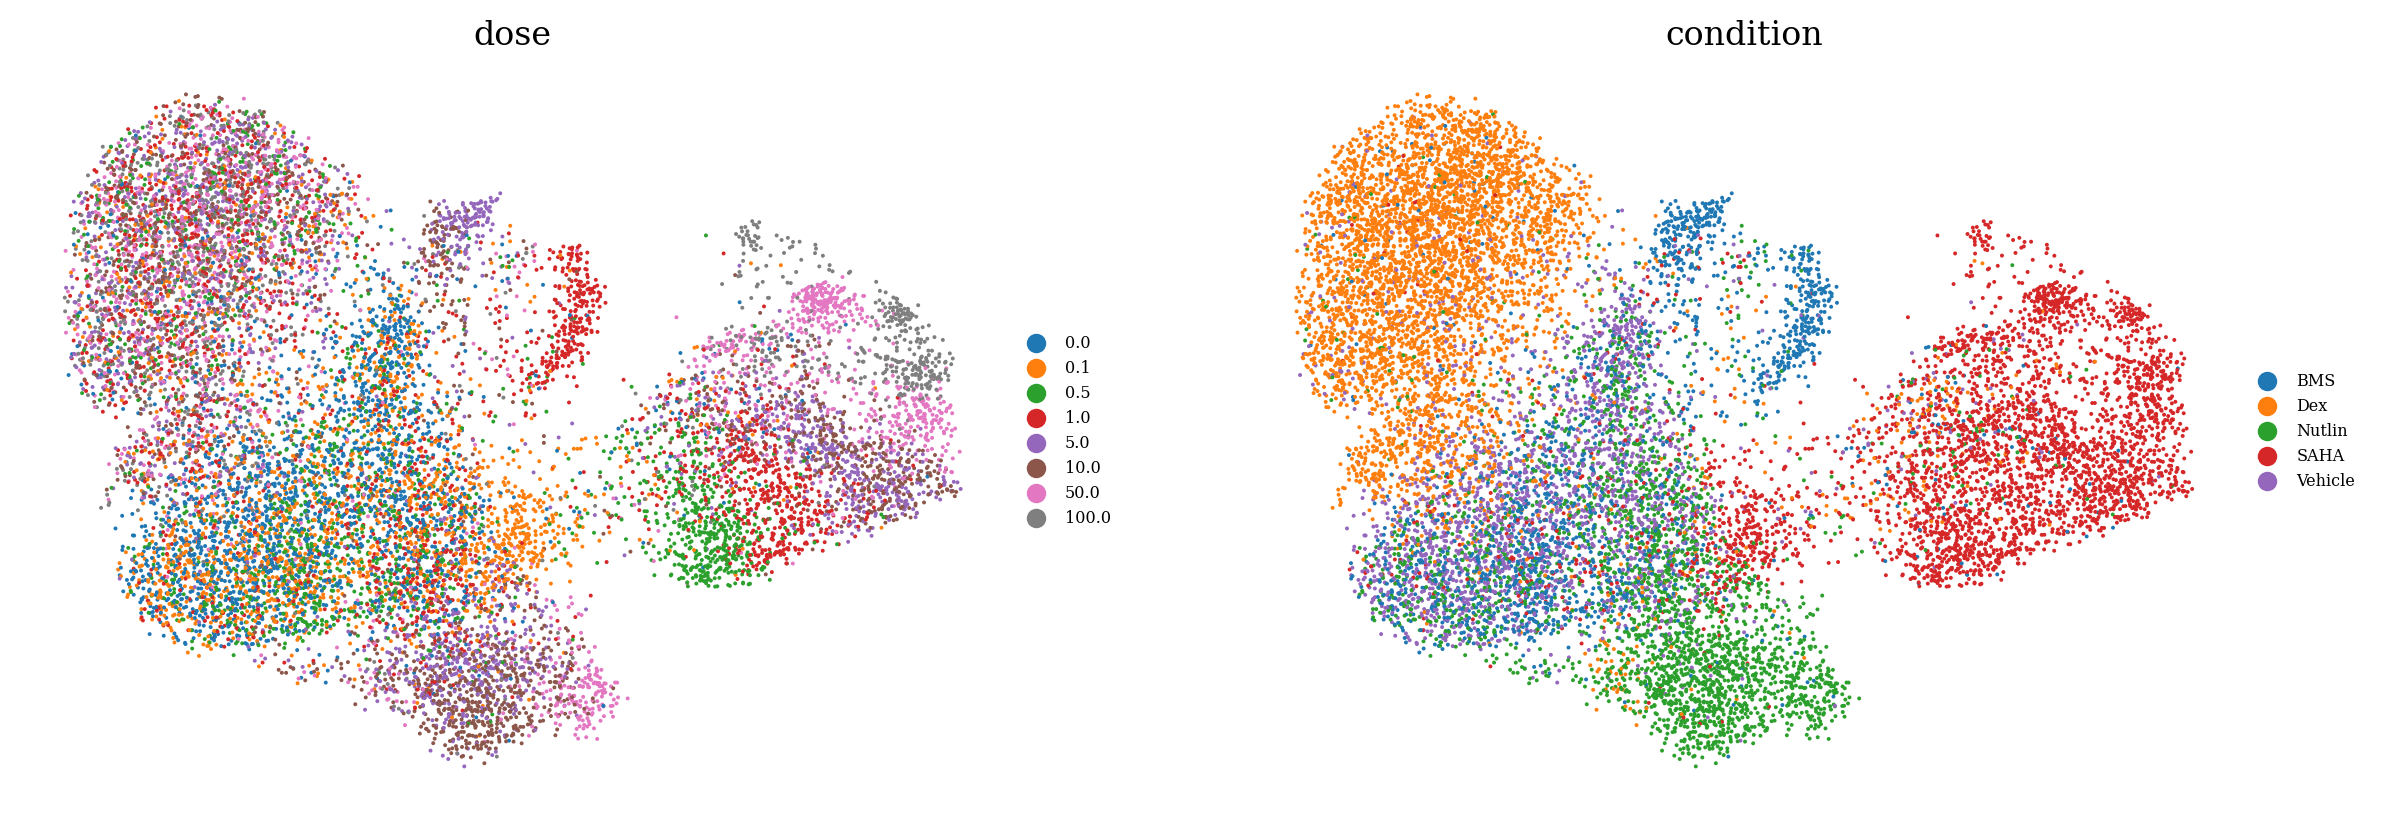

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

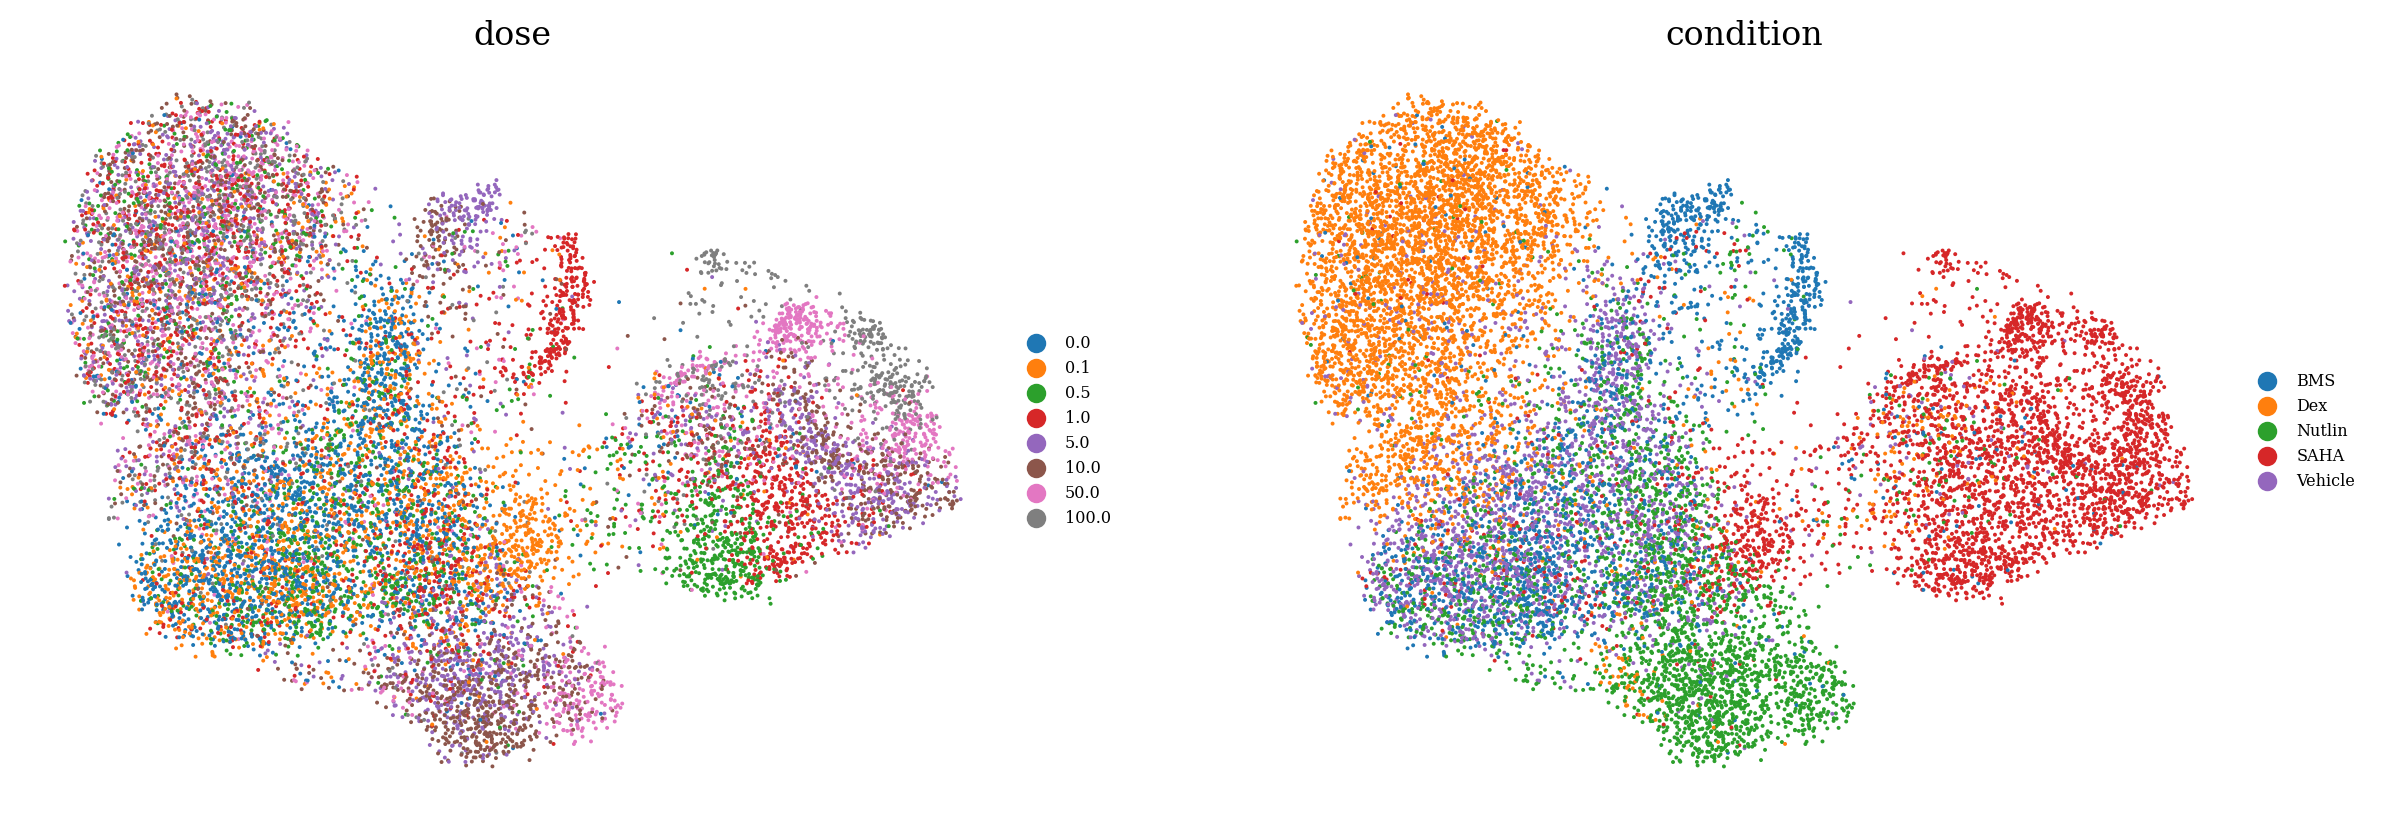

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<01:13,  6.25it/s]

  6%|▌         | 26/463 [00:00<00:03, 120.35it/s]

 11%|█         | 51/463 [00:00<00:02, 171.43it/s]

 16%|█▋        | 76/463 [00:00<00:01, 197.65it/s]

 22%|██▏       | 101/463 [00:00<00:01, 212.68it/s]

 27%|██▋       | 126/463 [00:00<00:01, 222.35it/s]

 33%|███▎      | 151/463 [00:00<00:01, 228.36it/s]

 38%|███▊      | 176/463 [00:00<00:01, 232.80it/s]

 43%|████▎     | 201/463 [00:00<00:01, 235.76it/s]

 49%|████▉     | 226/463 [00:01<00:00, 237.84it/s]

 54%|█████▍    | 251/463 [00:01<00:00, 239.38it/s]

 60%|█████▉    | 276/463 [00:01<00:00, 239.85it/s]

 65%|██████▌   | 301/463 [00:01<00:00, 241.30it/s]

 70%|███████   | 326/463 [00:01<00:00, 241.60it/s]

 76%|███████▌  | 351/463 [00:01<00:00, 242.13it/s]

 81%|████████  | 376/463 [00:01<00:00, 241.93it/s]

 87%|████████▋ | 401/463 [00:01<00:00, 242.35it/s]

 92%|█████████▏| 426/463 [00:01<00:00, 242.49it/s]

 97%|█████████▋| 451/463 [00:02<00:00, 241.78it/s]

100%|██████████| 463/463 [00:02<00:00, 224.14it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9922974760588235

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)